# Portfolio Analysis  

## Description

In [ ]:
#This portfolio is to run a scenario, where the investor is focusing not only in stock investment, but also on crypto investment. 
#The analysis will run different scenarios, including: portfolio of crypto only, portfolio of crypto/ASX stocks mix
#The result will be used to compare its performance on traditional equity indices such as: ASX20, ASX200, ASX300; or index-tracking ETFs.



## Initial Imports

In [22]:
import datetime as dt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from MCForecastTools import MCSimulation



%matplotlib inline

## Getting the Data for Crypto

In [3]:
btc_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\BTC-USD.csv")
BTC_daily_returns = pd.read_csv(btc_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
BTC_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
BTC_daily_returns = BTC_daily_returns.rename(columns={"Adj Close":"BTC/USD"})
BTC_daily_returns = BTC_daily_returns["2016-01-01":]
BTC_daily_returns

,BTC/USD
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991
...,...
2021-04-04,58758.554688
2021-04-05,59057.878906
2021-04-06,58192.359375


In [4]:
eth_returns_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\ETH-USD.csv")
ETH_daily_returns = pd.read_csv(eth_returns_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
ETH_daily_returns.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
ETH_daily_returns = ETH_daily_returns.rename(columns={"Adj Close":"ETH/USD"})
ETH_daily_returns = ETH_daily_returns["2016-01-01":]
ETH_daily_returns

,ETH/USD
Date,
2016-01-01,0.948024
2016-01-02,0.937124
2016-01-03,0.971905
2016-01-04,0.954480
2016-01-05,0.950176
...,...
2021-04-04,2093.122803
2021-04-05,2107.887207
2021-04-06,2118.378906


### Extras: Exchange Rate: USD to AUD

In [5]:
exchange_data_csv = Path(r"E:\OneDrive\Documents\GitHub\MonashFintech2021Project1\Financial Modelling\Crypto Portfolio\Resources\AUDUSD=X.csv")
daily_fx_rate = pd.read_csv(exchange_data_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
daily_fx_rate.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
daily_fx_rate = daily_fx_rate.rename(columns={"Adj Close":"AUD-USD"})
daily_fx_rate = daily_fx_rate["2016-01-01":]
daily_fx_rate

,AUD-USD
Date,
2016-01-01,0.727167
2016-01-04,0.728704
2016-01-05,0.718597
2016-01-06,0.716281
2016-01-07,0.708015
...,...
2021-04-02,0.761900
2021-04-05,0.762100
2021-04-06,0.765873


## Quantitative Analysis 

### Combine Data

In [6]:
crypto_df = pd.concat([
    BTC_daily_returns ,
    ETH_daily_returns ,
     
],axis="columns",join="inner")
crypto_df


,BTC/USD,ETH/USD
Date,,
2016-01-01,434.334015,0.948024
2016-01-02,433.437988,0.937124
2016-01-03,430.010986,0.971905
2016-01-04,433.091003,0.954480
2016-01-05,431.959991,0.950176
...,...,...
2021-04-04,58758.554688,2093.122803
2021-04-05,59057.878906,2107.887207
2021-04-06,58192.359375,2118.378906


### Calculate Returns, Mean, Standard Deviation 

In [7]:
# Define function to calculate returns, volatility
def portfolio_annualized_performance(weights, crypto_means, crypto_cov_matrix):
    crypto_returns = np.sum(crypto_means*weights ) *252
    crypto_std = np.sqrt(np.dot(weights.T, np.dot(crypto_cov_matrix, weights))) * np.sqrt(252)
    return crypto_std, crypto_returns

In [8]:
#Calculate daily returns
crypto_returns = crypto_df.pct_change()
crypto_returns

,BTC/USD,ETH/USD
Date,,
2016-01-01,NaN,NaN
2016-01-02,-0.002063,-0.011498
2016-01-03,-0.007907,0.037115
2016-01-04,0.007163,-0.017929
2016-01-05,-0.002611,-0.004509
...,...,...
2021-04-04,0.020045,0.031897
2021-04-05,0.005094,0.007054
2021-04-06,-0.014655,0.004977


Text(0, 0.5, 'daily returns')

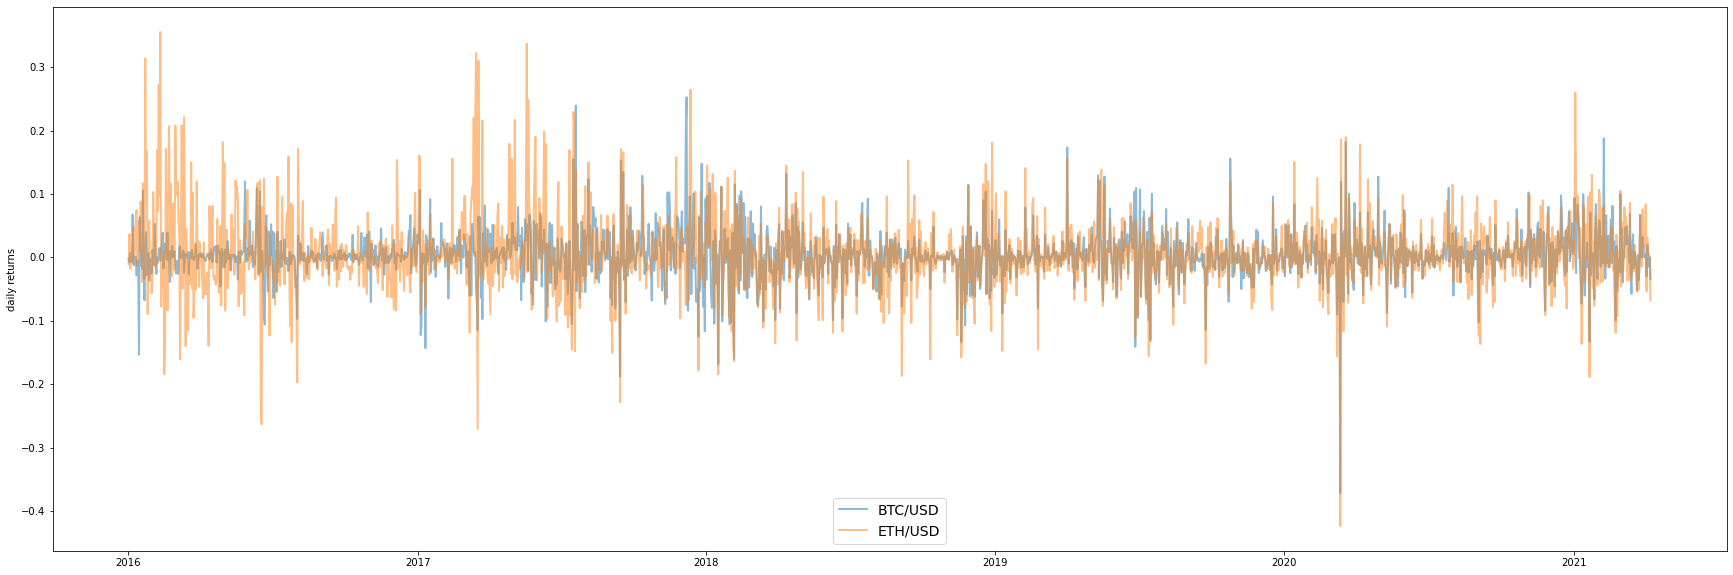

In [9]:
plt.figure(figsize=(30, 10))
for i in crypto_returns.columns.values:
    plt.plot(crypto_returns.index, crypto_returns[i], lw=2, alpha=0.5,label=i)
plt.legend(loc='lower center', fontsize=14)
plt.ylabel('daily returns')

In [10]:
#Calculate means
crypto_means = crypto_df.mean()
crypto_means

BTC/USD    8149.264033
ETH/USD     308.601623
dtype: float64

In [11]:
#Calculate Standard Deviation
crypto_std = crypto_df.std()
crypto_std

BTC/USD    10167.469318
ETH/USD      376.449510
dtype: float64

In [12]:
#Calculate Covariance Matrix
crypto_cov_matrix = crypto_returns.cov()
crypto_cov_matrix

,BTC/USD,ETH/USD
BTC/USD,0.001566,0.001266
ETH/USD,0.001266,0.003522


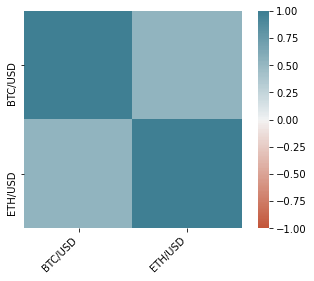

In [13]:
# Plot the correlation heatmap
crypto_corr = crypto_returns.corr()
ax = sns.heatmap(
    crypto_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Applying Markowitz Portfolio Theory (MPT) with Efficient Frontier

In [14]:
# Number of portfolios to simulate
num_portfolios = 10000
# Risk free rate (used for Sharpe ratio below)
# anchored on treasury bond rates (GTAUD5Y:GOV | Australia Bond 5 Year Yield)
risk_free_rate = 0.0169

In [15]:
def generate_random_portfolios(num_portfolios, crypto_means, crypto_cov_matrix, risk_free_rate):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
    # Array to store the weights of each equity
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign floats to our n equities
        weights = np.random.random(2)
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weight_array.append(weights)
        # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, crypto_means, crypto_cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array

----------------------------------------------------------------------------------------------------
Portfolio at maximum Sharpe Ratio

--Returns, volatility--

Annualized Return: 2053107.88
Annualized Volatility: 0.63


--Allocation at max Sharpe ratio--

            BTC/USD  ETH/USD
allocation    99.97     0.03
----------------------------------------------------------------------------------------------------


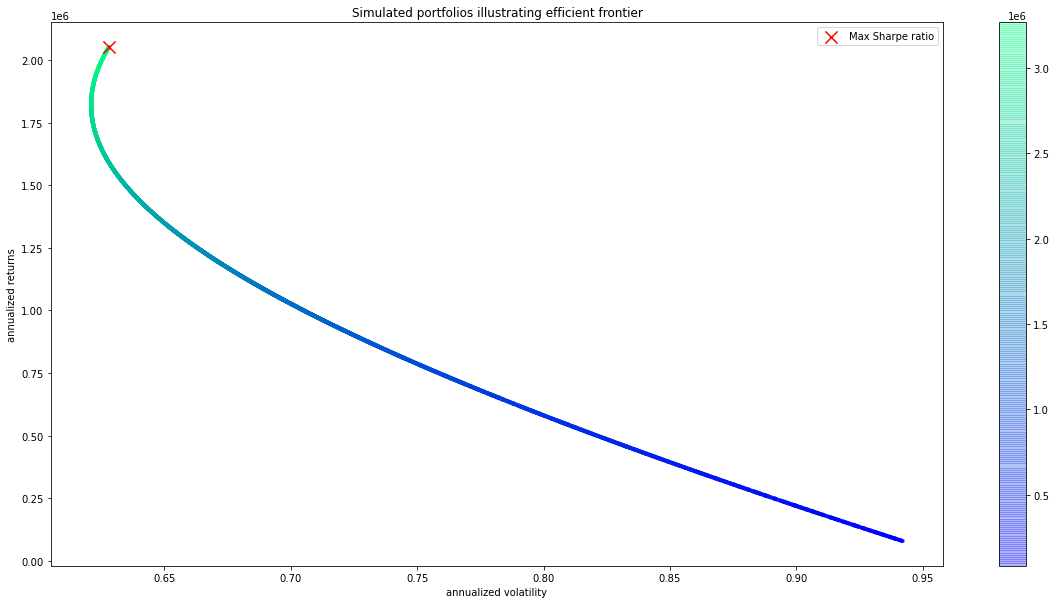

In [16]:
def display_simulated_portfolios(crypto_means, crypto_cov_matrix, num_portfolios, risk_free_rate):

    # pull results, weights from random portfolios
    results, weights = generate_random_portfolios(num_portfolios, crypto_means, crypto_cov_matrix, risk_free_rate)
    
    # pull the max portfolio Sharpe ratio (3rd element in results array from 
    # generate_random_portfolios function)
    max_sharpe_idx = np.argmax(results[2])

    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    stdev_portfolio, returns_portfolio = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=crypto_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    print("-"*100)
    print("Portfolio at maximum Sharpe Ratio\n")
    print("--Returns, volatility--\n")
    print("Annualized Return:", round(returns_portfolio,2))
    print("Annualized Volatility:", round(stdev_portfolio,2))
    
    print("\n")
    print("--Allocation at max Sharpe ratio--\n")
    print(max_sharpe_allocation)
    print("-"*100)
    
    plt.figure(figsize=(20, 10))
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Mark the portfolio w/ max Sharpe ratio
    plt.scatter(stdev_portfolio, returns_portfolio, marker='x',color='r',s=150, label='Max Sharpe ratio')
    plt.title('Simulated portfolios illustrating efficient frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=1.2)

display_simulated_portfolios(crypto_means, crypto_cov_matrix, num_portfolios, risk_free_rate)

In [17]:
#So what is happening to this formula? 
#Before we dive in, we need to understand the concept of max Sharpe Ratio: 
##The ratio is commonly used as a means of calculating the performance of an investment after 
##adjusting for its risk that allows investments of different risk profiles to be compared against each other.
## Max Sharpe Ratio means that investor will choose to go with higher risk, as in this case is Bitcoin, to achieve higher return
## The volatility gap between Bitcoin and Ethereum is significantly difference with Bitcoin volatility level is over the cloud, 
##therefore we can see why this model choose to go all-in in Bitcoin instead of allocating a significant portion to Ethereum

# Scenario Analysis

## 1st Scenario: Calculate expected returns in 5 years, based on the MPT allocation  

In [18]:
#Set weights
S1_weights = np.array([.9998, .0002])
# Calculate daily returns with allocated
crypto_returns['crypto_daily_returns'] = crypto_returns.dot(S1_weights)
crypto_returns

,BTC/USD,ETH/USD,crypto_daily_returns
Date,,,
2016-01-01,NaN,NaN,NaN
2016-01-02,-0.002063,-0.011498,-0.002065
2016-01-03,-0.007907,0.037115,-0.007898
2016-01-04,0.007163,-0.017929,0.007158
2016-01-05,-0.002611,-0.004509,-0.002612
...,...,...,...
2021-04-04,0.020045,0.031897,0.020047
2021-04-05,0.005094,0.007054,0.005095
2021-04-06,-0.014655,0.004977,-0.014652


In [19]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_even_dist = MCSimulation(stock_data, weights = [.99,.01], num_simulation = 500, num_trading_days = 252*5 )